In [2]:
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import base64
from IPython import display as dd

import norse.torch.functional.stdp as stdp
from norse.torch import PoissonEncoder
from norse.torch import LIFParameters, LIFFeedForwardState
from norse.torch.module.lif import LIFCell
from norse.torch.functional.stdp import STDPState, STDPParameters

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

In [4]:
def get_k_winnners_(z: torch.Tensor, k: int):
    """
    スパイク活性を制限するために、入力テンソルの各サンプルについて、
    k個以上のスパイクがある場合にランダムにk個を選択し、それ以外のスパイクを0に変更します。

    Args:
        z (torch.Tensor): ニューロンの出力スパイク活性を表すテンソル。
        k (int): 選択するスパイクの最大数。

    Returns:
        None: 元のテンソルを変更し、返り値はありません。
    """
    for i in range(z.size(0)):
        indices_of_ones = torch.nonzero(z[i]).squeeze(1)
        if len(indices_of_ones) > k:
            random_index = torch.randint(indices_of_ones.size(0), (k,))
            z[i] = torch.zeros_like(z[i])
            for j in random_index:
                z[i][indices_of_ones[j]] = 1.0
    return


def win_take_all_(state: LIFFeedForwardState, z: torch.Tensor, w: torch.Tensor):
    """
    Win-Take-Allアルゴリズムに基づいて、ニューロンの入力電流を更新します。

    Args:
        state (LIFFeedForwardState): LIFニューロンの状態を表すオブジェクト。
        z (torch.Tensor): ニューロンの出力スパイク活性を表すテンソル。
        w (torch.Tensor): 側方抑制の重みを表すテンソル。

    Returns:
        None: 元の状態オブジェクトを変更し、返り値はありません。
    """
    state.i.data = state.i + w * (z - torch.sum(z, dim=1, keepdim=True))
    return

In [12]:
class MNIST(nn.Module):
    def __init__(self, input_neurons: int, excitatory_neurons: int):
        super(MNIST, self).__init__()
        self.input_neurons = input_neurons
        self.excitatory_neurons = excitatory_neurons

        # 入力層から興奮層への全結合(weight: 0~1)
        self.liner_inp_exc = nn.Linear(input_neurons, excitatory_neurons, bias=False)
        nn.init.normal_(self.liner_inp_exc.weight, mean=0.3, std=0.05)
        # 興奮層のニューロン
        self.lifcell_exc = LIFCell(
            p=LIFParameters(tau_mem_inv=torch.as_tensor(1.0 / 50e-3))
        )
        # STDP用のパラメータ
        self.stdp_parameter = STDPParameters(
            eta_plus=torch.as_tensor(1e-2),
            eta_minus=torch.as_tensor(1e-4),
            stdp_algorithm="additive_step",
            hardbound=False,
        )
        self.norm = 78.4

    def forward(self, x: torch.Tensor, train: bool):
        time, batch_size, _, _, _ = x.shape
        state_exc = None

        with torch.no_grad():
            if train:
                state_stdp = STDPState(
                    t_pre=torch.zeros(self.input_neurons, device=x.device),
                    t_post=torch.zeros(self.excitatory_neurons, device=x.device),
                )
                for t in range(time):
                    z_pre = x[t, :, :, :].view(-1, self.input_neurons)
                    z = self.liner_inp_exc(z_pre)
                    z_post, state_exc = self.lifcell_exc(z, state_exc)
                    # get_k_winnners_(z=z_post, k=1)
                    win_take_all_(state=state_exc, z=z_post, w=torch.tensor(5.0))

                    w, state_stdp = stdp.stdp_step_linear(
                        z_pre=z_pre,
                        z_post=z_post,
                        w=self.liner_inp_exc.weight,
                        state_stdp=state_stdp,
                        p_stdp=self.stdp_parameter,
                    )
                    w = self.norm * w / torch.sum(w, dim=1, keepdim=True)
                    self.liner_inp_exc.weight.data = w
                return w

            else:
                firing_rate = torch.zeros(
                    (batch_size, self.excitatory_neurons), device=x.device
                )
                for t in range(time):
                    z = x[t, :, :, :].view(-1, self.input_neurons)
                    z = self.liner_inp_exc(z)
                    z, state_exc = self.lifcell_exc(z, state_exc)
                    win_take_all_(state=state_exc, z=z, w=torch.tensor(5.0))
                    firing_rate += z
                return firing_rate

    def save(self, file_path: str = "./mnist_model_parameters.pth"):
        torch.save(self.state_dict(), file_path)

    def load(self, file_path: str = "./mnist_model_parameters.pth"):
        self.load_state_dict(torch.load(file_path))

In [6]:
def visualize_tensor_as_grid(
    tensor: torch.Tensor,
    grid_rows: int,
    grid_cols: int,
    image_size: int = 28,
    save_path: str = None,
):
    """
    テンソルを指定された行数と列数のグリッドに変換して保存する関数。

    Args:
        tensor (torch.Tensor): 表示するテンソル
        grid_rows (int): グリッドの行数
        grid_cols (int): グリッドの列数
        image_size (int, optional): 画像のサイズ。デフォルトは28。
        save_path (str, optional): 画像を保存するパス。デフォルトはNone。

    Returns:
        None
    """
    # 勾配を切り離してテンソルをnumpy配列に変換
    tensor = tensor.to("cpu").detach().numpy()

    # 画像を配置するキャンバスの初期化
    canvas = np.zeros((grid_rows * image_size, grid_cols * image_size))

    # テンソルを画像に変換し、キャンバスに配置
    for i in range(grid_rows):
        for j in range(grid_cols):
            image = tensor[i * grid_cols + j].reshape(image_size, image_size)
            canvas[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = image

    # カスタムカラーマップの作成
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", [(0, "black"), (1, "green")]
    )

    # 画像を保存
    plt.figure(figsize=(5, 5))
    plt.imshow(canvas, cmap=cmap)
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.close()

In [13]:
seed = 0
gpu = True

# GPU使用の設定
if gpu and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed)
else:
    device = torch.device("cpu")
    torch.manual_seed(seed)
    torch.set_num_threads(os.cpu_count() - 1)

In [14]:
# オンライン学習
BATCH_SIZE = 1
EPOCH = 1
TIME = 300
interval = 10
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)
encoder = PoissonEncoder(TIME, f_max=64)

model = MNIST(28 * 28, 10 * 10)
model.to(device)
for _ in tqdm(range(EPOCH), desc="Epoch"):
    for i, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
        data = encoder(data).to(device)
        w = model(data, True)
        if i % interval == 0:
            visualize_tensor_as_grid(
                w, 10, 10, save_path=f"./weight/image_{int(i/interval)}.png"
            )
        if i * BATCH_SIZE % 10000 == 0:
            model.save(f"./{i*BATCH_SIZE}.pth")

model.save("./mnist_model_parameters.pth")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
class LabelAssignment:
    def __init__(
        self,
        n_labels: int,
        n_neurons: int,
        device: str,
    ):
        self.n_labels = n_labels
        self.n_neurons = n_neurons
        self.rates = torch.zeros((n_neurons, n_labels), device=device)
        self.proportions = torch.zeros((n_neurons, n_labels), device=device)
        self.assignments = torch.zeros(n_neurons, device=device)

    def assign_labels(self, firing_rate, target):
        for i in range(self.n_labels):
            n_labeled = torch.sum(target == i).float()
            if n_labeled > 0:
                indices = torch.nonzero(target == i).view(-1)
                self.rates[:, i] = self.rates[:, i] + (
                    torch.sum(firing_rate[indices], 0) / n_labeled
                )
        self.proportions = self.rates / self.rates.sum(1, keepdim=True)
        self.proportions[self.proportions != self.proportions] = 0
        self.assignments = torch.max(self.proportions, 1)[1]
        return

    def all_activity(self, firing_rate):
        n_samples = firing_rate.size(0)
        rates = torch.zeros((n_samples, self.n_labels), device=firing_rate.device)
        for i in range(self.n_labels):
            n_assigns = torch.sum(self.assignments == i).float()
            if n_assigns > 0:
                indices = torch.nonzero(self.assignments == i).view(-1)
                rates[:, i] = torch.sum(firing_rate[:, indices], 1) / n_assigns
        return torch.sort(rates, dim=1, descending=True)[1][:, 0]

    def proportion_weighting(self, firing_rate):
        n_samples = firing_rate.size(0)
        rates = torch.zeros((n_samples, self.n_labels), device=firing_rate.device)
        for i in range(self.n_labels):
            n_assigns = torch.sum(self.assignments == i).float()
            if n_assigns > 0:
                indices = torch.nonzero(self.assignments == i).view(-1)
                rates[:, i] += (
                    torch.sum((self.proportions[:, i] * firing_rate)[:, indices], 1)
                    / n_assigns
                )
        predictions = torch.sort(rates, dim=1, descending=True)[1][:, 0]
        return predictions

In [25]:
model_path = "./mnist_model_parameters.pth"

In [26]:
# ラベル付け
BATCH_SIZE = 1000
TIME = 300
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False
)
encoder = PoissonEncoder(TIME, f_max=64)

label = LabelAssignment(10, 10 * 10, device)

model = MNIST(28 * 28, 10 * 10)
model.load(model_path)
model.to(device)
for i, (data, target) in enumerate(tqdm(train_loader, desc="Label Assigments")):
    data = encoder(data).to(device)
    firing_rate = model(data, False)
    label.assign_labels(firing_rate, target)

print(label.assignments)

Label Assigments:   0%|          | 0/60 [00:00<?, ?it/s]

tensor([4, 6, 1, 7, 1, 1, 4, 1, 7, 6, 7, 9, 6, 4, 1, 1, 7, 4, 1, 9, 1, 1, 1, 9,
        1, 1, 1, 7, 7, 7, 1, 6, 7, 6, 9, 1, 1, 1, 7, 3, 1, 5, 7, 9, 8, 6, 1, 3,
        8, 7, 9, 1, 5, 1, 9, 7, 1, 7, 2, 1, 1, 3, 1, 1, 1, 3, 7, 4, 9, 9, 1, 4,
        1, 9, 9, 5, 3, 1, 1, 1, 4, 4, 5, 7, 7, 0, 1, 3, 1, 1, 7, 1, 5, 1, 9, 4,
        6, 4, 3, 1], device='cuda:0')


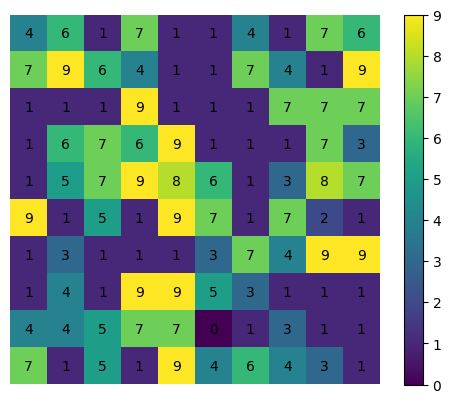

In [27]:
data = label.assignments.to("cpu").detach().numpy()
matrix_data = data.reshape(10, 10)

# マス目を表示
plt.imshow(matrix_data, cmap="viridis")
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(matrix_data[i, j]), ha="center", va="center", color="black")
plt.colorbar()
plt.axis("off")
plt.savefig("./labels", bbox_inches="tight")
plt.show()

In [28]:
# テスト
BATCH_SIZE = 1000
TIME = 300
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
)
encoder = PoissonEncoder(TIME, f_max=64)

model = MNIST(28 * 28, 10 * 10)
model.load(model_path)
model.to(device)

correct = 0
total = 0

for i, (data, target) in enumerate(tqdm(test_loader, desc="Test")):
    data = encoder(data).to(device)
    firing_rate = model(data, False)
    predict = label.proportion_weighting(firing_rate)

    for target_label, predicted_label in zip(target, predict):
        if target_label == predicted_label:
            correct += 1
        total += 1

accuracy = correct / total
print("Accuracy:", accuracy)

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.3895
